#Neural Style Transfer

##Overview

Neural style transfer (NST) is a technique that takes two images — a content image and a style reference image — and blends them together so that the output looks like the content image, but painted in the style of the style reference image.

##The Research Paper by Gatys et al.

A [research paper](https://arxiv.org/abs/1508.06576) titled **‘A Neural Algorithm of Artistic Style’** by Gatys et al, (originally released to ArXiv in 2015 and subsequently accepted by the CVPR conference in 2016), was the first in neural style transfer, and is still considered the most ground-breaking work till date in the domain.

##How Does it Work?


- We make use of a pre-trained convolutional neural network (VGG16 or VGG19, in our case) to extract the image details.
Starting from the network’s input layer, **the first few layer activations** represent low-level features like colors and textures (the **‘style’**).
As we step through the network, the **final few layers** represent higher-level features (the **‘content’**)— for example the cat’s eyes and ears in this case.
- This is why, we begin by taking our content image, feeding it through VGG19, and sampling the network activations at a late convolution layer `(conv4_2)`.
- Then, we take our style image, feed it through the same network, and sample the network activations at the early to middle convolution layers `(conv1_1, conv2_1, conv3_1, conv4_1, conv5_1)`.

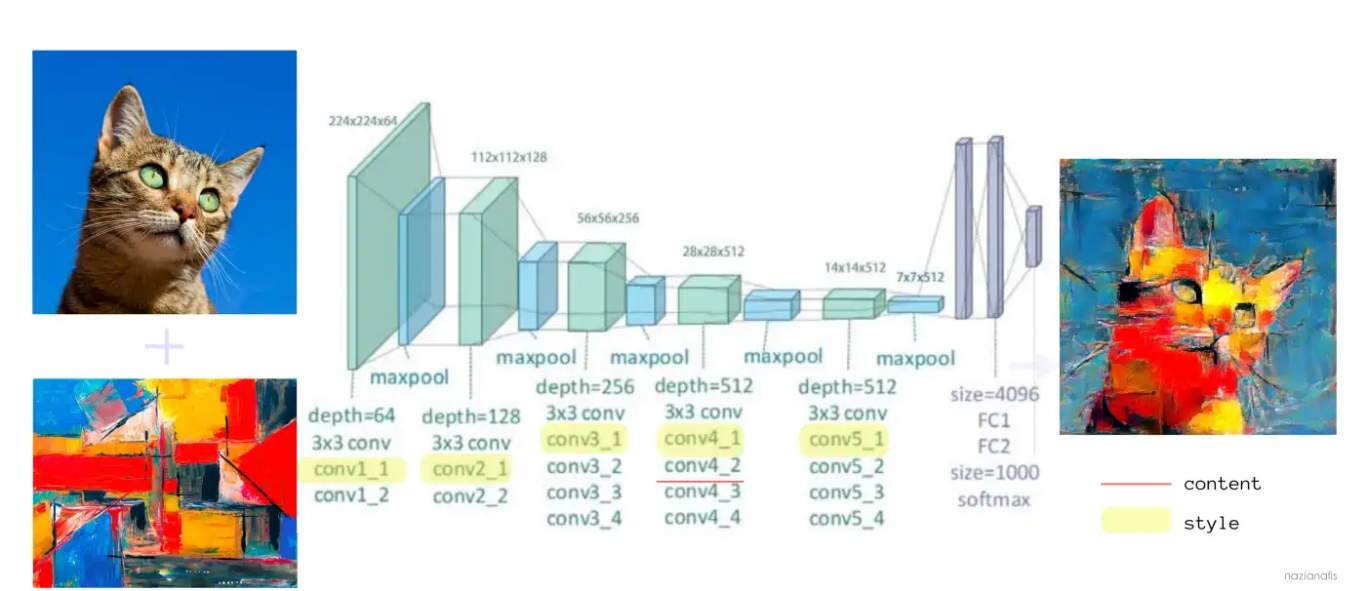

* These activations are encoded into a **Gram matrix representation**, and serve to denote the ‘style’ of the image.
* Our goal is to synthesize an output image that exhibits the contents of one image, with the style of another. For this, we calculate the following losses:
>1. **Content loss**, which is the Euclidean distance between the content image and the generated image.
>2. **Style loss**, which is the sum of Euclidean distances between the Gram matrices of the representations of the content image and the style image, extracted from different layers of VGG19.
>3. **Total variation** loss, which is used for spatial continuity between the pixels of the generated image, thereby denoising it and giving it visual coherence.
>4. **Total loss**, which is the sum of all of the above losses multiplied by their respective weights.
* An iterative **optimization technique** (ADAM or L-BFGS, in our case) is then employed to gradually minimize theses losses to achieve the desired results.

## Getting Started

### Cloning Repository

In [ ]:
! git clone https://github.com/AmirRaad/Neural-Style-Transfer.git

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 98 (delta 38), reused 84 (delta 26), pack-reused 0
Unpacking objects: 100% (98/98), done.


### Files Description

**utils.py**: Utilities and functions for image manipulation, model preperation and some math functions.

**vgg_nets.py**: contains the VGG models definition, specifying which layers are to be used for style representation and which one for content.

**video_utils.py**: A piece of code for creating video from resulting images.


In [ ]:
! apt install tree > /dev/null 2>&1
! tree --filelimit 5 ./Neural-Style-Transfer

./Neural-Style-Transfer
├── data
│   ├── content-images [9 entries exceeds filelimit, not opening dir]
│   └── style-images [18 entries exceeds filelimit, not opening dir]
├── utils.py
├── vgg_nets.py
└── video_utils.py

3 directories, 3 files


In [ ]:
! cp /content/Neural-Style-Transfer/utils.py utils.py
! cp /content/Neural-Style-Transfer/vgg_nets.py vgg_nets.py
! cp /content/Neural-Style-Transfer/video_utils.py video_utils.py

### Importing Modules

In [ ]:
import vgg_nets
import utils
import video_utils

In [ ]:
import torch
from torch.optim import Adam, LBFGS
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import os

### Loss Functions & Tuning Step

In [ ]:
def build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]

    current_set_of_feature_maps = neural_net(optimizing_img)

    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)

    style_loss = 0.0
    current_style_representation = [utils.gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)

    tv_loss = utils.total_variation(optimizing_img) # total variation

    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss

    return total_loss, content_loss, style_loss, tv_loss

In [ ]:
def make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    # Builds function that performs a step in the tuning loop
    def tuning_step(optimizing_img):
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config)
        # Computes gradients
        # computes the partial derivative of the output (loss) with respect to each of the input variables (pixels).
        total_loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss

    # Returns the function that will be called inside the tuning loop
    return tuning_step

### Major Function

In [ ]:
def neural_style_transfer(config):
    content_img_path = os.path.join(config['content_images_dir'], config['content_img_name'])   # \data\content-images\ + figures.jpg
    style_img_path = os.path.join(config['style_images_dir'], config['style_img_name'])         # same idea

    # (os.path.split) splits path from file name: [path, file name]. file name ex: figures.jpg
    #               combined_  + figures                                          +  _  +  vg_starry_night
    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + os.path.split(style_img_path)[1].split('.')[0]
    dump_path = os.path.join(config['output_img_dir'], out_dir_name)
    os.makedirs(dump_path, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = utils.prepare_img(content_img_path, config['height'], device)
    style_img = utils.prepare_img(style_img_path, config['height'], device)

    if config['init_method'] == 'random':
        # white_noise_img = np.random.uniform(-90., 90., content_img.shape).astype(np.float32)
        gaussian_noise_img = np.random.normal(loc=0, scale=90., size=content_img.shape).astype(np.float32)
        init_img = torch.from_numpy(gaussian_noise_img).float().to(device)
    elif config['init_method'] == 'content':
        init_img = content_img
    else:
        # init image has same dimension as content image - this is a hard constraint
        # feature maps need to be of same size for content image and init image
        style_img_resized = utils.prepare_img(style_img_path, np.asarray(content_img.shape[2:]), device)
        init_img = style_img_resized

    # we are tuning optimizing_img's pixels! (that's why requires_grad=True)
    optimizing_img = Variable(init_img, requires_grad=True)

    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = utils.prepare_model(config['model'], device)
    print(f'Using {config["model"]} in the optimization procedure.')
    summary(neural_net, init_img.shape[1:])

    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)

    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [utils.gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]

    # magic numbers in general are a big no no - some things in this code are left like this by design to avoid clutter
    num_of_iterations = {
        "lbfgs": 1000,
        "adam": 3000,
    }

    #
    # Start of optimization procedure
    #
    if config['optimizer'] == 'adam':
        optimizer = Adam((optimizing_img,), lr=1e1)
        tuning_step = make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
        for cnt in range(num_of_iterations[config['optimizer']]):
            total_loss, content_loss, style_loss, tv_loss = tuning_step(optimizing_img)
            with torch.no_grad():
                print(f'Adam | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                utils.save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']], should_display=False)
    elif config['optimizer'] == 'lbfgs':
        # line_search_fn does not seem to have significant impact on result
        optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations['lbfgs'])
        cnt = 0

        def closure():
            nonlocal cnt
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
            if total_loss.requires_grad:
                total_loss.backward()
            with torch.no_grad():
                if (cnt % 50) == 0 or cnt == num_of_iterations[config['optimizer']] - 1:
                  print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                  utils.save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']], should_display=True)

            cnt += 1
            return total_loss

        optimizer.step(closure)

    return dump_path


### Setting Configuration & Main Implementation

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Using vgg19 in the optimization procedure.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 300]           1,792
              ReLU-2         [-1, 64, 400, 300]               0
            Conv2d-3         [-1, 64, 400, 300]          36,928
              ReLU-4         [-1, 64, 400, 300]               0
         MaxPool2d-5         [-1, 64, 200, 150]               0
            Conv2d-6        [-1, 128, 200, 150]          73,856
              ReLU-7        [-1, 128, 200, 150]               0
            Conv2d-8        [-1, 128, 200, 150]         147,584
              ReLU-9        [-1, 128, 200, 150]               0
        MaxPool2d-10         [-1, 128, 100, 75]               0
           Conv2d-11         [-1, 256, 100, 75]         295,168
             ReLU-12         [-1, 256, 100, 75]               0
           Conv2d-13         [-1, 256, 100, 75]         590,

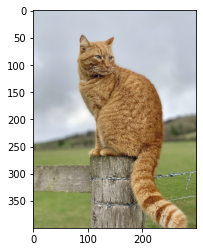

L-BFGS | iteration: 050, total loss=16157315072.0000, content_loss=8518488159.1797, style loss=7626262031.2500, tv loss=12564260.0000


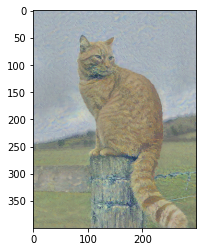

L-BFGS | iteration: 100, total loss=13112695808.0000, content_loss=7284754028.3203, style loss=5814930937.5000, tv loss=13010990.0000


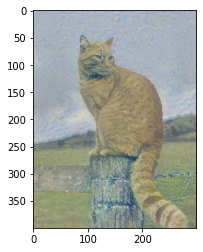

L-BFGS | iteration: 150, total loss=12192940032.0000, content_loss=6812136840.8203, style loss=5367366093.7500, tv loss=13436418.0000


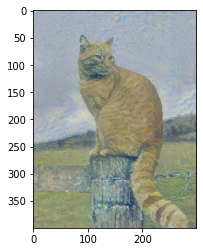

L-BFGS | iteration: 200, total loss=11761245184.0000, content_loss=6571962280.2734, style loss=5175491250.0000, tv loss=13791836.0000


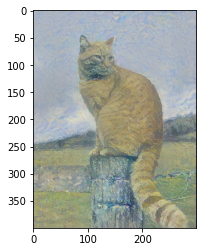

L-BFGS | iteration: 250, total loss=11510038528.0000, content_loss=6428983764.6484, style loss=5066980781.2500, tv loss=14073362.0000


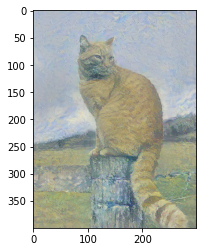

L-BFGS | iteration: 300, total loss=11348680704.0000, content_loss=6331036376.9531, style loss=5003345156.2500, tv loss=14299568.0000


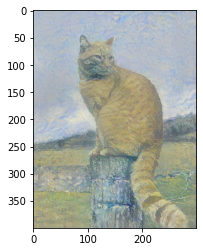

L-BFGS | iteration: 350, total loss=11237311488.0000, content_loss=6264507446.2891, style loss=4958302500.0000, tv loss=14500966.0000


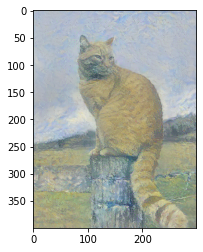

L-BFGS | iteration: 400, total loss=11155289088.0000, content_loss=6213781738.2812, style loss=4926837187.5000, tv loss=14670896.0000


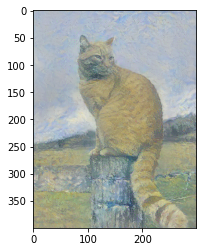

L-BFGS | iteration: 450, total loss=11094810624.0000, content_loss=6178256835.9375, style loss=4901741718.7500, tv loss=14812630.0000


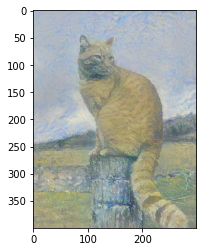

L-BFGS | iteration: 500, total loss=11046592512.0000, content_loss=6151143188.4766, style loss=4880506406.2500, tv loss=14941945.0000


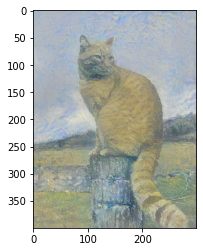

L-BFGS | iteration: 550, total loss=11008936960.0000, content_loss=6127675781.2500, style loss=4866210468.7500, tv loss=15050816.0000


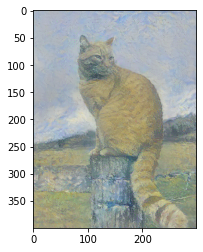

L-BFGS | iteration: 600, total loss=10978477056.0000, content_loss=6107700195.3125, style loss=4855627500.0000, tv loss=15150008.0000


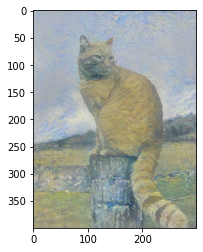

L-BFGS | iteration: 650, total loss=10953499648.0000, content_loss=6094770507.8125, style loss=4843486406.2500, tv loss=15242697.0000


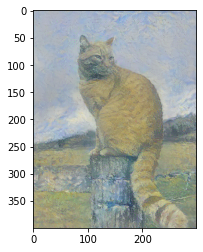

L-BFGS | iteration: 700, total loss=10930965504.0000, content_loss=6079855346.6797, style loss=4835773593.7500, tv loss=15336478.0000


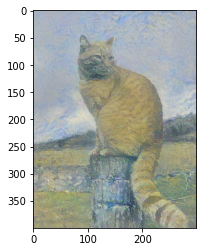

L-BFGS | iteration: 750, total loss=10911233024.0000, content_loss=6066940917.9688, style loss=4828869843.7500, tv loss=15422544.0000


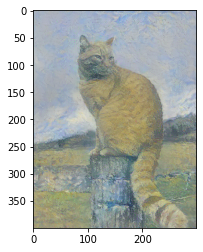

L-BFGS | iteration: 800, total loss=10893864960.0000, content_loss=6057939453.1250, style loss=4820422968.7500, tv loss=15502045.0000


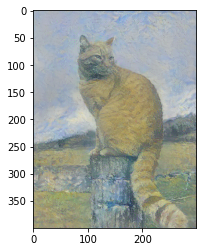

L-BFGS | iteration: 850, total loss=10877838336.0000, content_loss=6046850585.9375, style loss=4815412968.7500, tv loss=15574958.0000


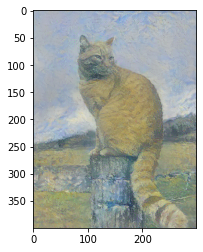

L-BFGS | iteration: 900, total loss=10863026176.0000, content_loss=6037875366.2109, style loss=4809502500.0000, tv loss=15648516.0000


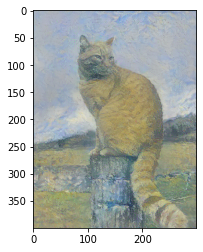

L-BFGS | iteration: 950, total loss=10849576960.0000, content_loss=6029821777.3438, style loss=4804041093.7500, tv loss=15714437.0000


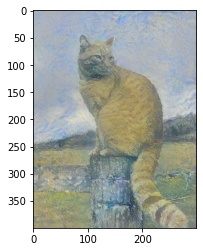

L-BFGS | iteration: 999, total loss=10837808128.0000, content_loss=6022637939.4531, style loss=4799394375.0000, tv loss=15776034.0000


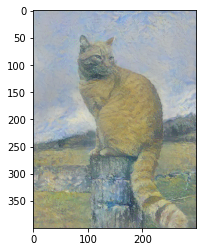

In [ ]:
if __name__ == "__main__":
    #
    # fixed args - don't change these unless you have a good reason
    #
    default_resource_dir = os.path.join("/content/Neural-Style-Transfer", 'data')
    content_images_dir = os.path.join(default_resource_dir, 'content-images')
    style_images_dir = os.path.join(default_resource_dir, 'style-images')
    output_img_dir = os.path.join(default_resource_dir, 'output-images')
    img_format = (4, '.jpg')  # saves images in the format: %04d.jpg

    #
    # modifiable args - feel free to play with these (only small subset is exposed by design to avoid cluttering)
    # sorted so that the ones on the top are more likely to be changed than the ones on the bottom
    #
    optimization_config = dict()
    optimization_config["content_img_name"] = 'cat.jpg'
    optimization_config["style_img_name"] = 'vg_wheat_field.jpg'
    optimization_config["height"] = 400 # height of content and style images

    optimization_config["content_weight"] = 5e6 # weight factor for content loss
    optimization_config["style_weight"] = 3e4   # weight factor for style loss
    optimization_config["tv_weight"] = 1e0      # weight factor for total variation loss

    optimization_config["optimizer"] = 'lbfgs'  # choices:['lbfgs', 'adam']
    optimization_config["model"] = 'vgg19'
    optimization_config["init_method"] = 'content' # choices:['random', 'content', 'style']
    optimization_config["saving_freq"] = -1 # saving frequency for intermediate images (-1 means only final)

    # some values of weights that worked for figures.jpg, vg_starry_night.jpg (starting point for finding good images)

    # lbfgs, content init -> (cw, sw, tv) = (1e5, 3e4, 1e0)
    # lbfgs, style   init -> (cw, sw, tv) = (1e5, 1e1, 1e-1)
    # lbfgs, random  init -> (cw, sw, tv) = (1e5, 1e3, 1e0)

    # adam, content init -> (cw, sw, tv, lr) = (1e5, 1e5, 1e-1, 1e1)
    # adam, style   init -> (cw, sw, tv, lr) = (1e5, 1e2, 1e-1, 1e1)
    # adam, random  init -> (cw, sw, tv, lr) = (1e5, 1e2, 1e-1, 1e1)

    optimization_config['content_images_dir'] = content_images_dir
    optimization_config['style_images_dir'] = style_images_dir
    optimization_config['output_img_dir'] = output_img_dir
    optimization_config['img_format'] = img_format

    # original NST (Neural Style Transfer) algorithm (Gatys et al.)
    results_path = neural_style_transfer(optimization_config)

    # uncomment this if you want to create a video from images dumped during the optimization procedure
    # video_utils.create_video_from_intermediate_results(results_path, img_format)

## Acknowledgements

- Aleksa Gordic’s [implementation](https://github.com/gordicaleksa/pytorch-neural-style-transfer).
- [A Lightweight PyTorch Implementation of Neural Style Transfer](https://medium.com/geekculture/a-lightweight-pytorch-implementation-of-neural-style-transfer-86603e5eb551)
- The original paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al.
- The original paper [Exploring the Neural Algorithm of Artistic Style](https://arxiv.org/abs/1602.07188).
- The original paper on [VGG Nets](https://arxiv.org/abs/1409.1556).
